In [1]:
import numpy as np
import pandas as pd
import math
import random
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import pchip
from IPython.display import display, HTML, Image
import json
import os
import matplotlib.ticker as ticker
import re
import seaborn as sns
#%matplotlib inline

In [2]:
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
 })

In [3]:
DATA_PATH = '/Users/lucascraemer/bachelor/bench_results'

In [4]:
DATABASES = (
    'redis',
    'keydb', # open source multi-threaded redis fork
    'mini-redis', # redis server built with tokio
    'redis-cluster',
)

In [5]:
DB_NAME_MAP = {
    'redis': 'Redis',
    'keydb': 'KeyDB',
    'mini-redis': 'Mini-Redis (Tokio)',
    'redis-cluster': 'Redis Cluster',
}
DB_NAME = lambda name: DB_NAME_MAP[name]

In [6]:
PERC_MAP = {
    0.95: 'P95',
    0.99: 'P99',
    0.999: 'P99.9',
    0.9999: 'P99.99',
}
PERC_NAME = lambda name: PERC_MAP[name]

In [7]:
DB_NAME('redis')

'Redis'

In [8]:
vCPUs = 24

In [9]:
THREADS = (
    1,
    2, 
    4, 
    8, 
    12,
)

In [10]:
# there were always 24 MEMTIER THREADs active on the EC2 instance that generated the load
# so the overall client count is 24*CLIENTS_PER_MEMTIER_THREAD
CLIENTS_PER_MEMTIER_THREAD = (
    1,
    4, 
    8, 
    16,
    32,
) # 2^N

In [11]:
results = {}
for db in DATABASES:
    results[db] = {}
    for thread in THREADS:
        if db == 'redis-cluster' and thread < 4:
            continue
        results[db][thread] = {}
        for clients in CLIENTS_PER_MEMTIER_THREAD:
            results[db][thread][clients] = {}
            with open(f'{DATA_PATH}/{db}/{thread}-{clients}.json', 'r') as json_file:
                results[db][thread][clients]['result'] = json.loads(json_file.read())

In [12]:
results['redis'][2][32]['result']['ALL STATS']['Totals']['KB/sec']

190310.56

In [13]:
MARKERS = ['o', 's', 'D', '^', 'v', '*', '1']
MARKER = lambda idx : MARKERS[idx]

In [14]:
LINES = ['-', '--', '-.', ':']
LINE = lambda idx : LINES[idx]

In [15]:
imp_baseline = lambda baseline, val : int(round(((val - baseline) / baseline) * 100.0, 0))

In [16]:
DB_NAMES = list(map(lambda db: DB_NAME(db), DATABASES))

In [17]:
def new_threads_df():
    return pd.DataFrame(columns=['Threads'] + DB_NAMES)

In [18]:
def threads_to_int(df):
    df['Threads'] = df['Threads'].astype(int)
    return df.set_index('Threads')

In [19]:
def plt_heatmap(df, save = None, revert = True, title = None, suptitle = None):
    df = threads_to_int(df)
    fig = plt.figure(1)
    svm = sns.heatmap(df, cmap='RdYlGn_r' if revert else 'RdYlGn', linewidths=0.5, annot=True, cbar=False, fmt='g')
    if save:
        #plt.savefig(save)
        figure = svm.get_figure()    
        figure.savefig(save)
    if title:
        plt.title(title)
    if suptitle:
        plt.suptitle(suptitle)
    #plt.savefig(f'./latencies/latencies_threads_{thread}_clients_{clients}.pgf')
    plt.show()

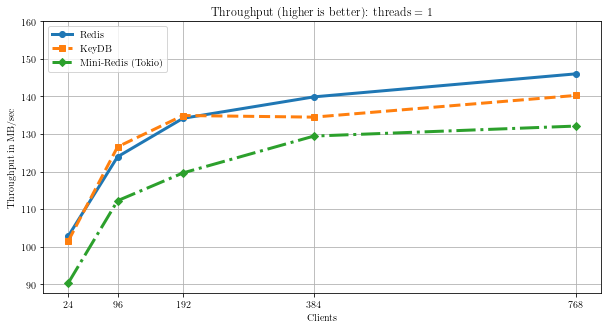

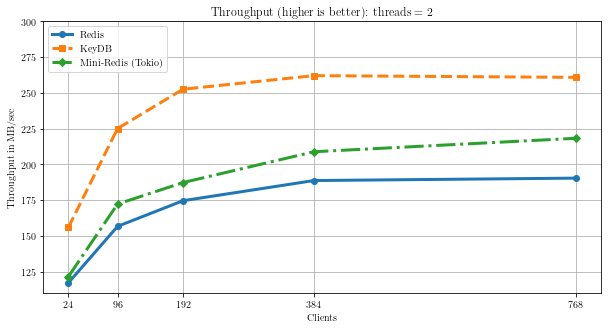

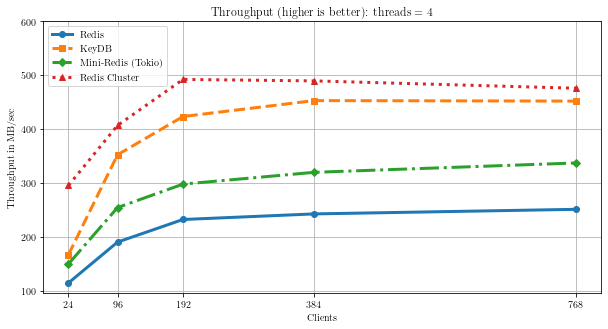

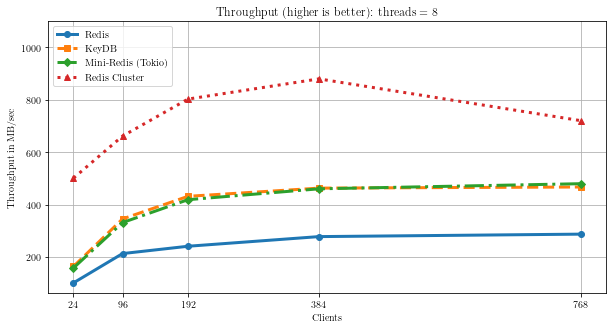

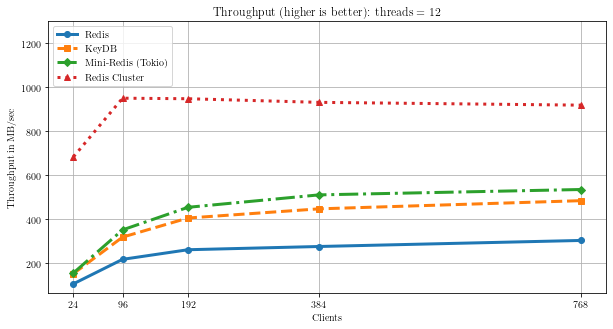

In [20]:
clients_x = list(map(lambda clients: clients * vCPUs, CLIENTS_PER_MEMTIER_THREAD))
limits = (
    160,
    300,
    600,
    1100,
    1300,
)
db_throughputs = {}
thread_speedups = {}
df_speedups = pd.DataFrame(columns=['Threads'] + DB_NAMES)
for thread, limit in zip(THREADS, limits):
    plt.figure(figsize=(10,5))
    for idx, db in enumerate(DATABASES):
        if db == 'redis-cluster' and thread < 4:
            if thread >= 2:
                # thread_speedups[thread][DB_NAME(db)] = 'N/A'
                thread_speedups[thread][DB_NAME(db)] = float('NaN')
            continue
        throughput_y = []
        for clients in CLIENTS_PER_MEMTIER_THREAD:
            throughput_y.append(results[db][thread][clients]['result']['ALL STATS']['Totals']['KB/sec'] / 1000)
        # print(throughput_y)
        avg_throughput = np.mean(throughput_y)
        if db in db_throughputs:
            db_throughputs[db]['avg_throughput'].append(avg_throughput)
            db_throughputs[db]['threads'].append(thread)
        else:
            db_throughputs[db] = {}
            
            db_throughputs[db]['avg_throughput'] = [avg_throughput]
            db_throughputs[db]['threads'] = [thread]
        # print(f'db = {db}, threads = {thread}: medium concurrency: {throughput_y[2]}')
        if thread >= 2:
            if thread not in thread_speedups:
                thread_speedups[thread] = {}
            baseline = db_throughputs['redis']['avg_throughput'][0]
            percent = imp_baseline(baseline, avg_throughput)
            thread_speedups[thread][DB_NAME(db)] = percent
            # display(HTML(f'<div>db = {db}, threads = {thread}<br>Avg. performance increase cmp. Redis baseline: <strong>{percent}%</strong><br>Speedup: {speedup}</div>'))
        # else:
        #    if thread not in thread_speedups:
        #        thread_speedups[thread] = {}
        #        thread_speedups_medium[thread] = {}
        #    thread_speedups[thread][DB_NAME(db)] = 'n/a'
        #    thread_speedups_medium[thread][DB_NAME(db)] = 'n/a'
        plt.plot(clients_x, throughput_y, LINE(idx), linewidth=3, label=DB_NAME(db), marker=MARKER(idx))
    plt.xlabel('Clients')
    plt.ylabel('Throughput in MB/sec')
    plt.title(f'Throughput (higher is better): threads = {thread}')
    plt.grid()
    plt.xticks(clients_x)
    plt.ylim(ymax=limit)
    plt.legend(loc='upper left')
    plt.savefig(f'./throughput_threads/throughput_threads_{thread}.pgf')
    plt.show()

for threads, dbs in thread_speedups.items():
    dbs['Threads'] = threads
    df_speedups = df_speedups.append(dbs, ignore_index=True)


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2.0,28.0,79.0,40.0,NaN
1,4.0,59.0,185.0,110.0,234.0
2,8.0,73.0,189.0,185.0,451.0
3,12.0,80.0,179.0,210.0,585.0


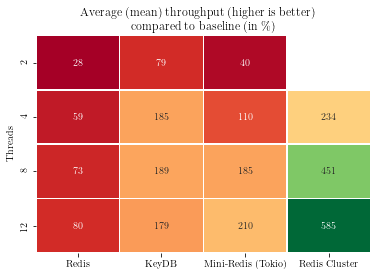

In [21]:
display(HTML(df_speedups.to_html()))
plt_heatmap(df_speedups, f'./average_throughput/heatmap.pgf', False, 'compared to baseline (in \%)', 'Average (mean) throughput (higher is better)')
#print(df_speedups.to_latex(index=False))

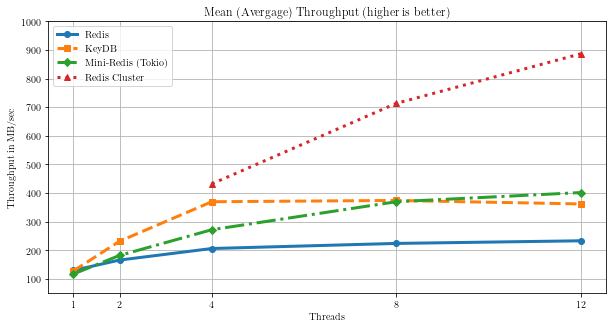

In [22]:
plt.figure(figsize=(10,5))
for idx, db in enumerate(DATABASES):
    plt.plot(db_throughputs[db]['threads'], db_throughputs[db]['avg_throughput'], LINE(idx), linewidth=3, label=DB_NAME(db), marker=MARKER(idx))
plt.xlabel('Threads')
plt.ylabel('Throughput in MB/sec')
plt.title(f'Mean (Avergage) Throughput (higher is better)')
plt.grid()
plt.xticks(THREADS)
plt.yticks(np.linspace(100, 1000, num=10))
plt.ylim(ymax=1000, ymin=50)
plt.legend(loc='upper left')
plt.savefig(f'./average_throughput/average_throughput.pgf')
plt.show()

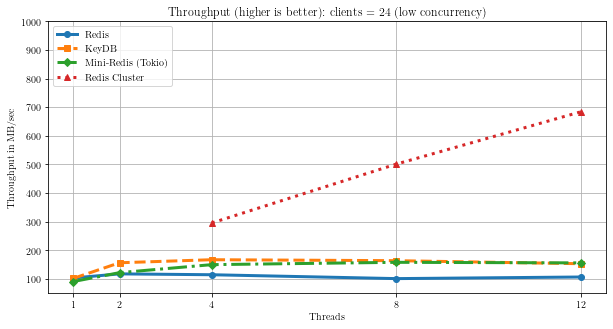

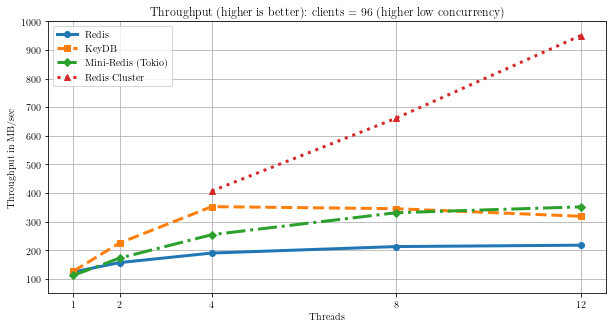

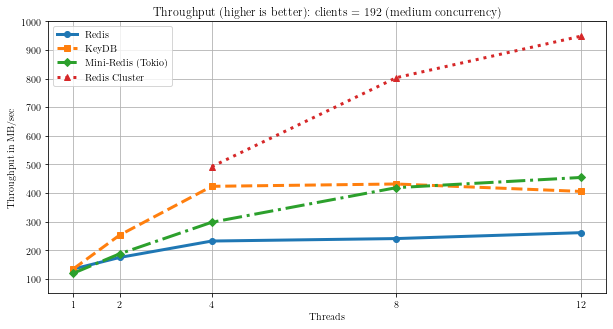

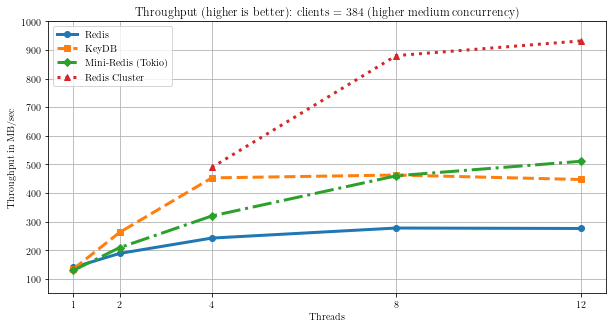

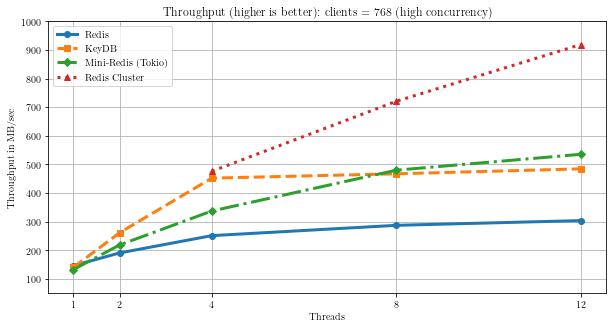

In [23]:
# CLIENTS_PER_MEMTIER_THREAD_PLOT = (
#    (1, 'low concurrency', ),
#    (8, 'medium concurrency'),
#    (32, 'high concurrency'),
#)
CLIENTS_PER_MEMTIER_THREAD_PLOT = (
    (1, 'low concurrency'),
    (4, 'higher low concurrency'),
    (8, 'medium concurrency'),
    (16, 'higher medium concurrency'),
    (32, 'high concurrency'),
)
for idx_c, (clients, desc) in enumerate(CLIENTS_PER_MEMTIER_THREAD_PLOT):
    plt.figure(figsize=(10,5))
    for idx, db in enumerate(DATABASES):
        threads_x = []
        throughput_y = []
        for thread in THREADS:
            if db == 'redis-cluster' and thread < 4:
                continue
            threads_x.append(thread)
            throughput = results[db][thread][clients]['result']['ALL STATS']['Totals']['KB/sec'] / 1000
            throughput_y.append(throughput)
                
        plt.plot(threads_x, throughput_y, LINE(idx), linewidth=3, label=DB_NAME(db), marker=MARKER(idx))
    plt.xlabel('Threads')
    plt.ylabel('Throughput in MB/sec')
    plt.title(f'Throughput (higher is better): clients = {clients * vCPUs} ({desc})')
    plt.grid()
    plt.xticks(THREADS)
    plt.yticks(np.linspace(100, 1000, num=10))
    plt.ylim(ymax=1000, ymin=50)
    plt.legend(loc='upper left')
    #plt.savefig(f'./throughput_clients/throughput_clients_{clients}.pgf')
    plt.show()

In [24]:
def perc_str_to_int(str):
    try:
        return int(str.split('%')[0])
    except:
        return None

,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2.0,14.0,52.0,18.0,NaN
1,4.0,11.0,62.0,45.0,187.0
2,8.0,-2.0,59.0,53.0,387.0
3,12.0,3.0,48.0,51.0,564.0


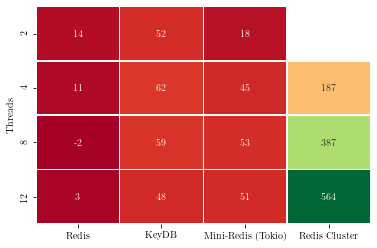

,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2.0,26.0,82.0,39.0,NaN
1,4.0,53.0,184.0,105.0,228.0
2,8.0,72.0,178.0,167.0,434.0
3,12.0,75.0,157.0,184.0,667.0


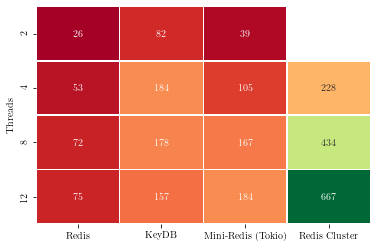

,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2.0,30.0,88.0,40.0,NaN
1,4.0,73.0,215.0,122.0,267.0
2,8.0,79.0,221.0,212.0,498.0
3,12.0,95.0,202.0,238.0,606.0


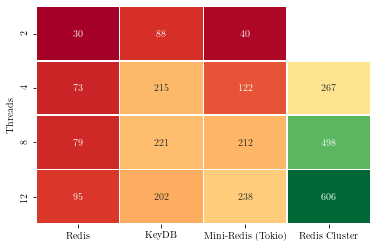

,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2.0,35.0,87.0,49.0,NaN
1,4.0,73.0,224.0,128.0,250.0
2,8.0,98.0,231.0,229.0,529.0
3,12.0,97.0,220.0,265.0,566.0


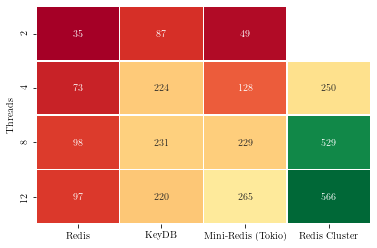

,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2.0,30.0,79.0,49.0,NaN
1,4.0,72.0,209.0,131.0,226.0
2,8.0,96.0,220.0,228.0,393.0
3,12.0,108.0,232.0,266.0,529.0


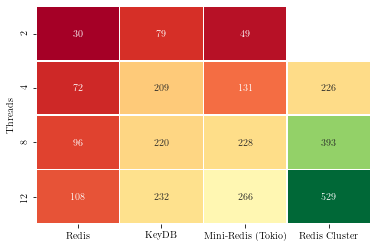

In [25]:
dfs_speedups = {}
redis_baseline = []
for idx_c, clients in enumerate(CLIENTS_PER_MEMTIER_THREAD):
    dfs_speedups[clients] = pd.DataFrame(columns=['Threads'] + DB_NAMES)
    for thread in THREADS:
        row = {}
        row['Threads'] = thread
        thresh = False
        for idx, db in enumerate(DATABASES):
            if db == 'redis-cluster' and thread < 4:
                #row[DB_NAME(db)] = f'N/A'
                row[DB_NAME(db)] = float('NaN')
                continue
            throughput = results[db][thread][clients]['result']['ALL STATS']['Totals']['KB/sec'] / 1000
            if thread == 1 and db == 'redis':
                redis_baseline.append(throughput)
            if thread >= 2:
                base = redis_baseline[idx_c]
                row[DB_NAME(db)] = imp_baseline(base, throughput)
                thresh = True
        if thresh:
            dfs_speedups[clients] = dfs_speedups[clients].append(row, ignore_index=True)
    
    dfs_speedups[clients].reset_index(drop=True, inplace=True)
    display(HTML(dfs_speedups[clients].to_html()))
    plt_heatmap(dfs_speedups[clients], f'./throughput_heatmap/throughput_clients_{clients}.pgf', False)
    dfs_speedups[clients]
    #print(dfs_speedups[clients].to_latex(index=False))


In [26]:
def amdahl(proportion_multithreading, threads):
    return round(1/((1 - proportion_multithreading) + (proportion_multithreading / threads)), 2)

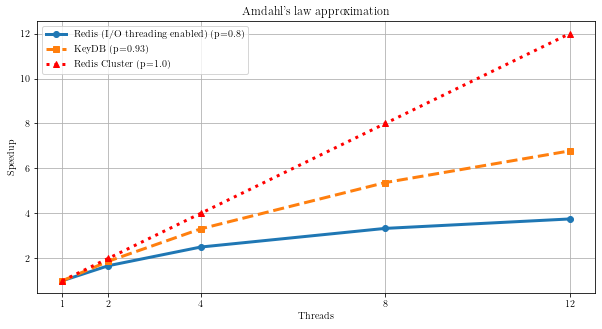

In [27]:
DATABASE_SPEEDUPS = (
    ('Redis (I/O threading enabled)', 0.8),
    ('KeyDB', 0.93),
    (None, None),
    ('Redis Cluster', 1.0),
)
plt.figure(figsize=(10,5))
for idx, (db, p) in enumerate(DATABASE_SPEEDUPS):
        if db is None:
            continue
        throughput_y = []
        for threads in THREADS:
            throughput_y.append(amdahl(p, threads))
        plt.plot(THREADS, throughput_y, LINE(idx), label=f'{db} (p={p})', linewidth=3, marker=MARKER(idx), c='r' if db == 'Redis Cluster' else None)
plt.xlabel('Threads')
plt.ylabel('Speedup')
plt.grid()
plt.title(f'Amdahl\'s law approximation')
plt.xticks(THREADS)
plt.legend(loc='upper left')
plt.savefig(f'./amdahl/amdahl.pgf')
plt.show()

In [28]:
#
# hdr-plot.py v0.2.3 - A simple HdrHistogram plotting script.
# Copyright © 2018 Bruno Bonacci - Distributed under the Apache License v 2.0
#
# A standalone plotting script for https://github.com/giltene/wrk2 and
#  https://github.com/HdrHistogram/HdrHistogram.
#
regex = re.compile(r'\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)')

def parse_percentiles(file):
    lines       = [ line for line in open(file) if re.match(regex, line)]
    values      = [ re.findall(regex, line)[0] for line in lines]
    pctles      = [ (float(v[0]), float(v[1]), int(v[2]), float(v[3])) for v in values]
    percentiles = pd.DataFrame(pctles, columns=['Latency', 'Percentile', 'TotalCount', 'inv-pct'])
    return percentiles

def plot_percentiles(title, ylim, percentiles, labels):
    fig, ax = plt.subplots(figsize=(8,5))
    # plot values
    for idx, data in enumerate(percentiles):
        ax.plot(data['Percentile'], data['Latency'], LINE(idx), linewidth=3)

    # set axis and legend
    ax.grid()
    ax.set(xlabel='Percentile',
           ylabel='Latency (milliseconds)',
          )
    plt.suptitle(f'Latency Percentiles (lower is better):')
    plt.title(title)
    ax.set_xscale('logit')
    plt.xticks([0.25, 0.5, 0.9, 0.99, 0.999, 0.9999])
    majors = ["25%", "50%", "90%", "99%", "99.9%", "99.99%"]
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(majors))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    plt.ylim(ymax=ylim, ymin=0)
    plt.legend(labels=labels, loc='upper left')

    return fig, ax

In [29]:
PERCENTILES = (0.95, 0.99, 0.999, 0.9999)

In [30]:
get_tail_percentiles = lambda df_percentile, percentiles = (0.95, 0.99, 0.999, 0.9999) : reduce(lambda tail_latencies, percentile : tail_latencies + [df_percentile[df_percentile['Percentile'] >= percentile]['Latency'].min()], percentiles, [])

In [31]:
for db in DATABASES:
    for thread in THREADS:
        if db == 'redis-cluster' and thread < 4:
            continue
        for clients in CLIENTS_PER_MEMTIER_THREAD:
            results[db][thread][clients]['hdrhist'] = parse_percentiles(f'{DATA_PATH}/{db}/{thread}-{clients}_FULL_RUN_1.txt')
            results[db][thread][clients]['tail'] = get_tail_percentiles(results[db][thread][clients]['hdrhist'], PERCENTILES)

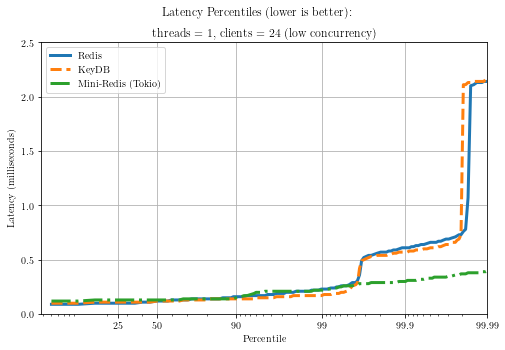

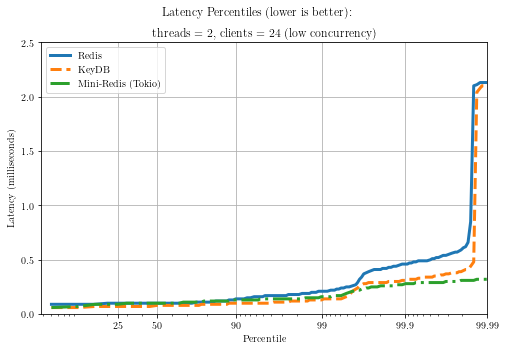

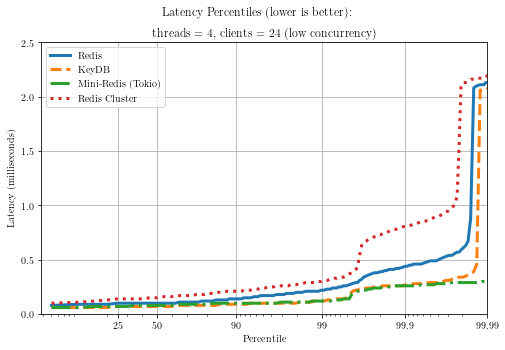

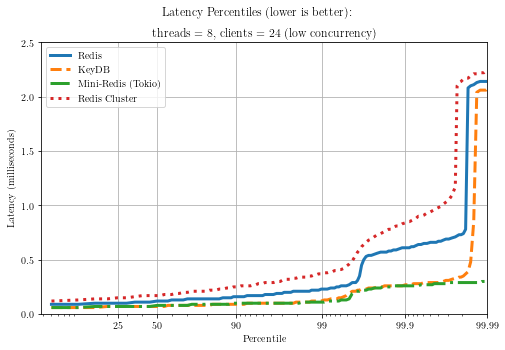

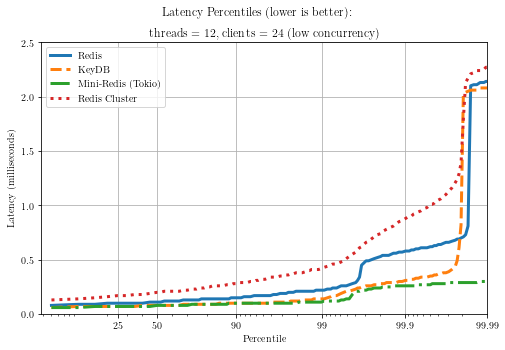

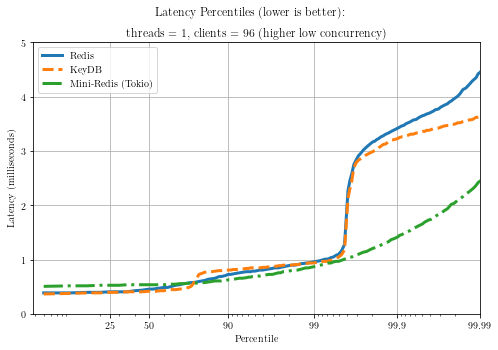

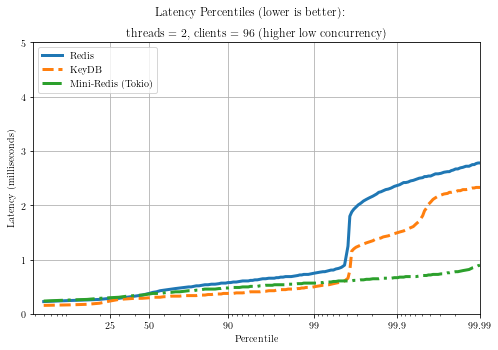

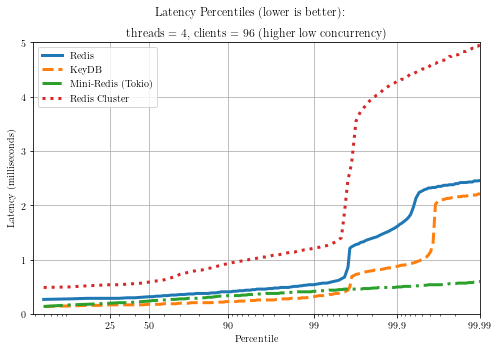

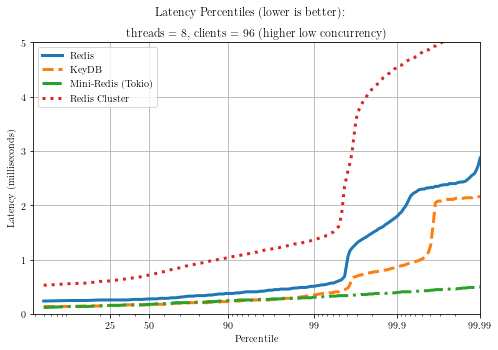

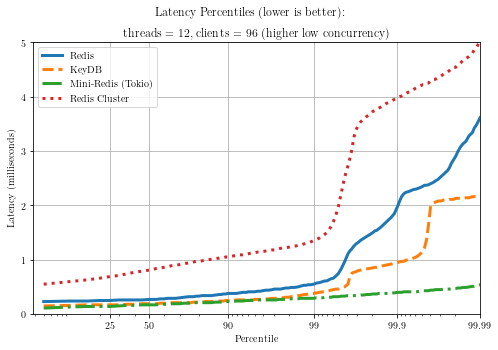

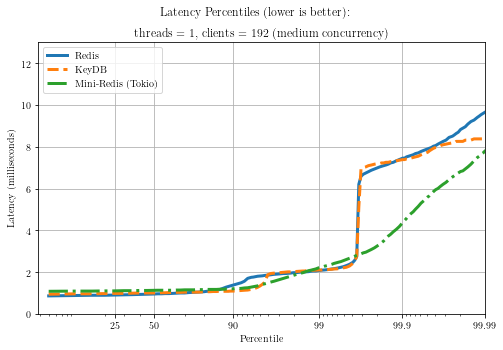

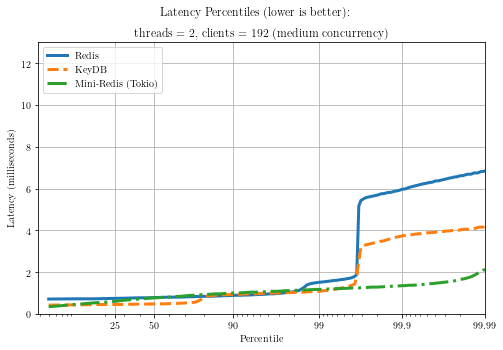

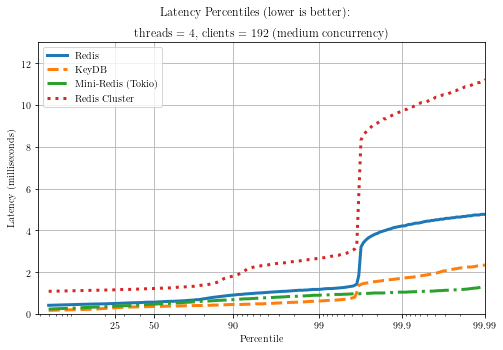

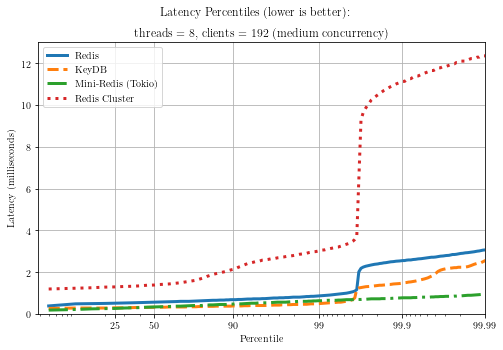

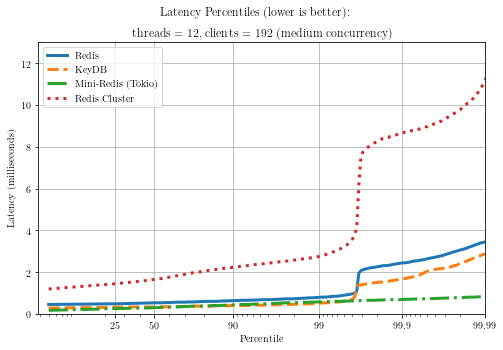

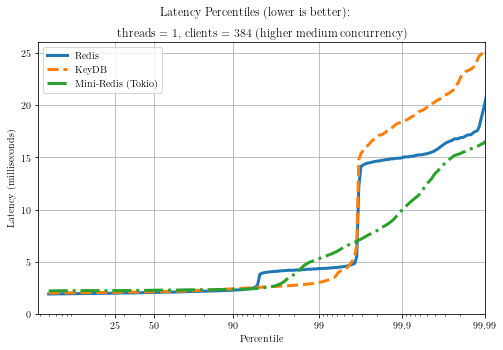

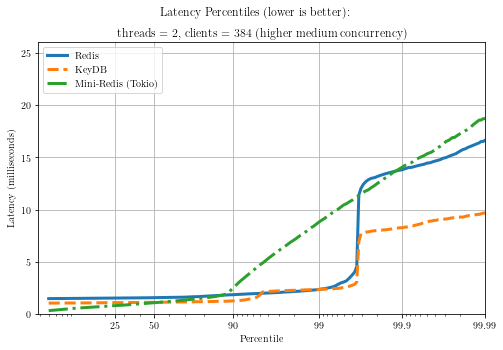

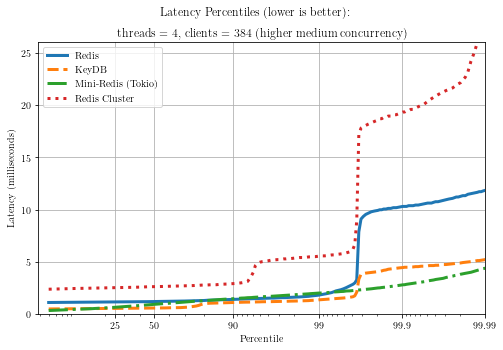

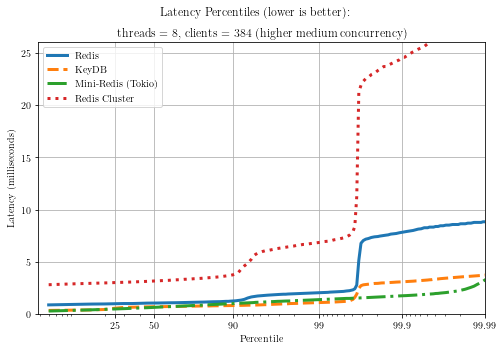

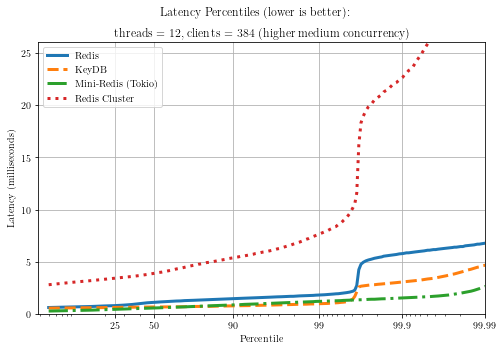

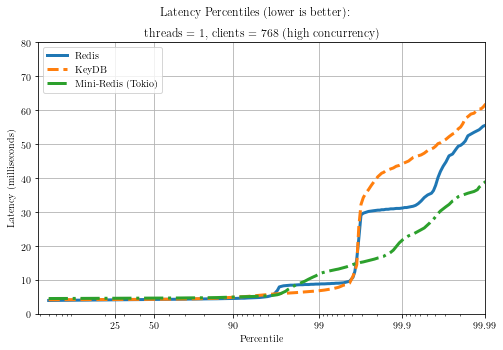

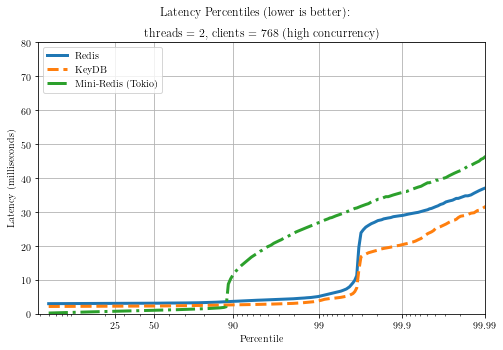

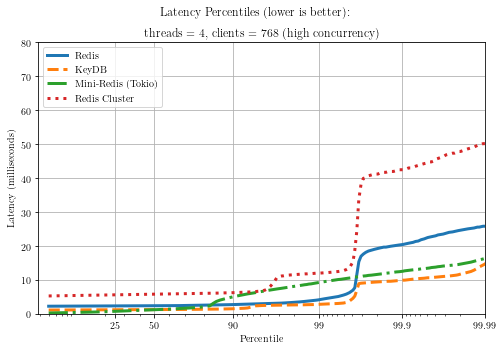

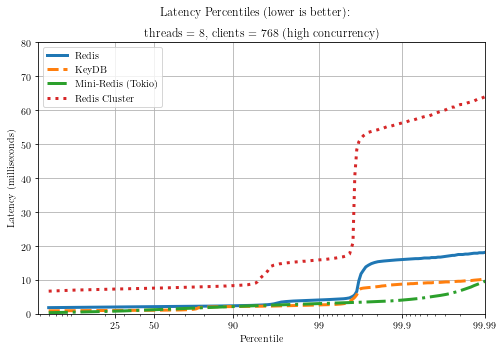

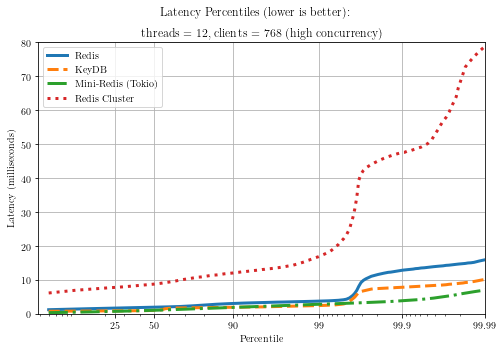

In [32]:
CLIENTS_PER_MEMTIER_THREAD_PLOT = (
    (1, 'low concurrency', 2.5),
    (8, 'medium concurrency', 13),
    (32, 'high concurrency', 80),
)
CLIENTS_PER_MEMTIER_THREAD_PLOT = (
    (1, 'low concurrency', 2.5),
    (4, 'higher low concurrency', 5),
    (8, 'medium concurrency', 13),
    (16, 'higher medium concurrency', 26),
    (32, 'high concurrency', 80),
)
for clients, desc, ylim in CLIENTS_PER_MEMTIER_THREAD_PLOT:
    for thread in THREADS:
        latencies = []
        labels = []
        for idx, db in enumerate(DATABASES):
            if db == 'redis-cluster' and thread < 4:
                continue
            latencies.append(results[db][thread][clients]['hdrhist'])
            labels.append(DB_NAME(db))
        fig, ax = plot_percentiles(f'threads = {thread}, clients = {clients * vCPUs} ({desc})', ylim, latencies, labels)
        plt.savefig(f'./latencies/latencies_threads_{thread}_clients_{clients}.pgf')
        plt.show()

Percentile: 0.95, Clients: 24


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-6%,-41%,-18%,N/A
1,4,0%,-41%,-41%,41%
2,8,0%,-41%,-41%,65%
3,12,0%,-41%,-41%,88%


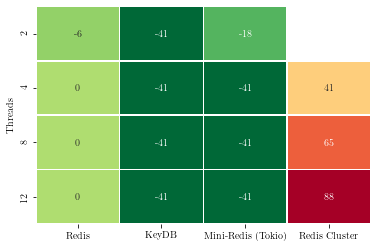

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &   -6\% &  -41\% &               -18\% &           N/A \\
       4 &    0\% &  -41\% &               -41\% &           41\% \\
       8 &    0\% &  -41\% &               -41\% &           65\% \\
      12 &    0\% &  -41\% &               -41\% &           88\% \\
\bottomrule
\end{tabular}

Percentile: 0.95, Clients: 96


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-20%,-48%,-35%,N/A
1,4,-43%,-68%,-54%,29%
2,8,-48%,-67%,-67%,44%
3,12,-48%,-66%,-68%,43%


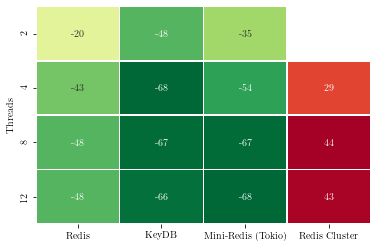

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -20\% &  -48\% &               -35\% &           N/A \\
       4 &  -43\% &  -68\% &               -54\% &           29\% \\
       8 &  -48\% &  -67\% &               -67\% &           44\% \\
      12 &  -48\% &  -66\% &               -68\% &           43\% \\
\bottomrule
\end{tabular}

Percentile: 0.95, Clients: 192


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-48%,-46%,-42%,N/A
1,4,-45%,-73%,-58%,26%
2,8,-60%,-77%,-70%,40%
3,12,-63%,-76%,-73%,31%


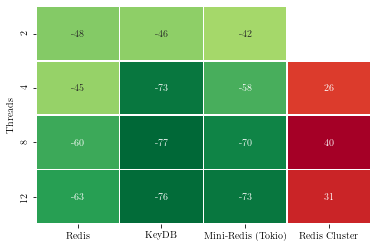

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -48\% &  -46\% &               -42\% &           N/A \\
       4 &  -45\% &  -73\% &               -58\% &           26\% \\
       8 &  -60\% &  -77\% &               -70\% &           40\% \\
      12 &  -63\% &  -76\% &               -73\% &           31\% \\
\bottomrule
\end{tabular}

Percentile: 0.95, Clients: 384


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-48%,-52%,23%,N/A
1,4,-61%,-69%,-57%,30%
2,8,-54%,-77%,-70%,55%
3,12,-59%,-78%,-74%,54%


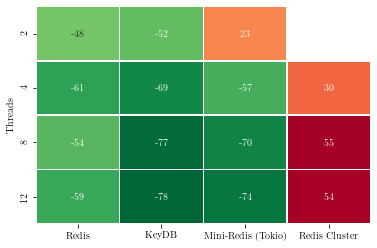

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -48\% &  -52\% &                23\% &           N/A \\
       4 &  -61\% &  -69\% &               -57\% &           30\% \\
       8 &  -54\% &  -77\% &               -70\% &           55\% \\
      12 &  -59\% &  -78\% &               -74\% &           54\% \\
\bottomrule
\end{tabular}

Percentile: 0.95, Clients: 768


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-16%,-42%,277%,N/A
1,4,-39%,-49%,34%,38%
2,8,-46%,-53%,-49%,113%
3,12,-31%,-57%,-54%,166%


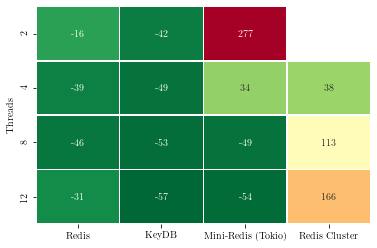

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -16\% &  -42\% &               277\% &           N/A \\
       4 &  -39\% &  -49\% &                34\% &           38\% \\
       8 &  -46\% &  -53\% &               -49\% &          113\% \\
      12 &  -31\% &  -57\% &               -54\% &          166\% \\
\bottomrule
\end{tabular}

Percentile: 0.99, Clients: 24


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-9%,-39%,-30%,N/A
1,4,-4%,-48%,-48%,35%
2,8,0%,-43%,-52%,65%
3,12,-4%,-39%,-48%,87%


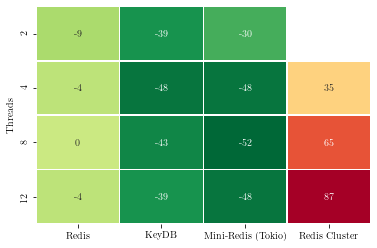

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &   -9\% &  -39\% &               -30\% &           N/A \\
       4 &   -4\% &  -48\% &               -48\% &           35\% \\
       8 &    0\% &  -43\% &               -52\% &           65\% \\
      12 &   -4\% &  -39\% &               -48\% &           87\% \\
\bottomrule
\end{tabular}

Percentile: 0.99, Clients: 96


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-22%,-47%,-41%,N/A
1,4,-43%,-66%,-57%,26%
2,8,-46%,-63%,-68%,42%
3,12,-41%,-60%,-69%,41%


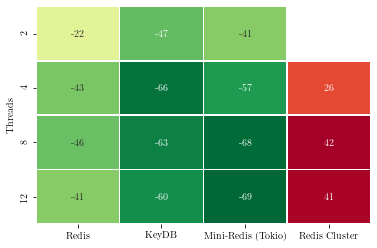

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -22\% &  -47\% &               -41\% &           N/A \\
       4 &  -43\% &  -66\% &               -57\% &           26\% \\
       8 &  -46\% &  -63\% &               -68\% &           42\% \\
      12 &  -41\% &  -60\% &               -69\% &           41\% \\
\bottomrule
\end{tabular}

Percentile: 0.99, Clients: 192


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-27%,-48%,-44%,N/A
1,4,-43%,-70%,-57%,28%
2,8,-58%,-76%,-70%,46%
3,12,-61%,-75%,-72%,33%


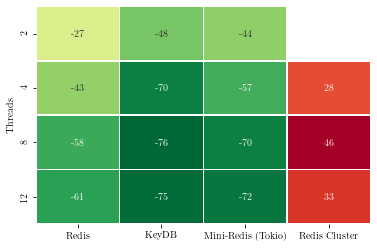

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -27\% &  -48\% &               -44\% &           N/A \\
       4 &  -43\% &  -70\% &               -57\% &           28\% \\
       8 &  -58\% &  -76\% &               -70\% &           46\% \\
      12 &  -61\% &  -75\% &               -72\% &           33\% \\
\bottomrule
\end{tabular}

Percentile: 0.99, Clients: 384


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-45%,-46%,106%,N/A
1,4,-57%,-68%,-54%,28%
2,8,-53%,-75%,-68%,58%
3,12,-58%,-77%,-72%,78%


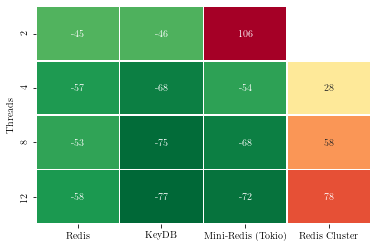

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -45\% &  -46\% &               106\% &           N/A \\
       4 &  -57\% &  -68\% &               -54\% &           28\% \\
       8 &  -53\% &  -75\% &               -68\% &           58\% \\
      12 &  -58\% &  -77\% &               -72\% &           78\% \\
\bottomrule
\end{tabular}

Percentile: 0.99, Clients: 768


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-39%,-54%,207%,N/A
1,4,-51%,-68%,6%,36%
2,8,-53%,-69%,-65%,80%
3,12,-57%,-72%,-67%,94%


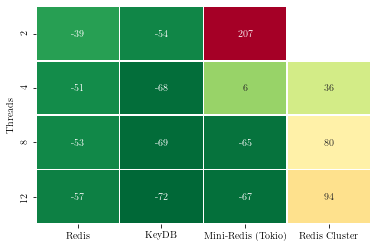

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -39\% &  -54\% &               207\% &           N/A \\
       4 &  -51\% &  -68\% &                 6\% &           36\% \\
       8 &  -53\% &  -69\% &               -65\% &           80\% \\
      12 &  -57\% &  -72\% &               -67\% &           94\% \\
\bottomrule
\end{tabular}

Percentile: 0.999, Clients: 24


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-25%,-49%,-54%,N/A
1,4,-28%,-56%,-57%,33%
2,8,0%,-56%,-57%,38%
3,12,-5%,-49%,-57%,44%


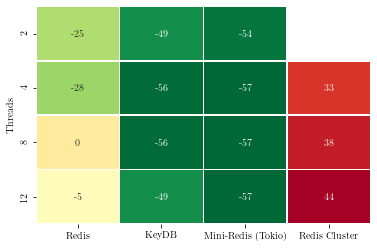

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -25\% &  -49\% &               -54\% &           N/A \\
       4 &  -28\% &  -56\% &               -57\% &           33\% \\
       8 &    0\% &  -56\% &               -57\% &           38\% \\
      12 &   -5\% &  -49\% &               -57\% &           44\% \\
\bottomrule
\end{tabular}

Percentile: 0.999, Clients: 96


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-31%,-56%,-80%,N/A
1,4,-53%,-74%,-85%,25%
2,8,-47%,-75%,-88%,33%
3,12,-42%,-72%,-88%,16%


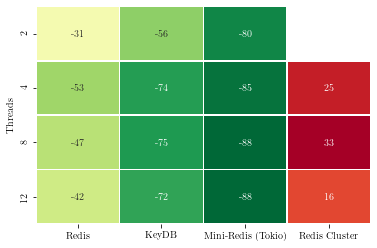

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -31\% &  -56\% &               -80\% &           N/A \\
       4 &  -53\% &  -74\% &               -85\% &           25\% \\
       8 &  -47\% &  -75\% &               -88\% &           33\% \\
      12 &  -42\% &  -72\% &               -88\% &           16\% \\
\bottomrule
\end{tabular}

Percentile: 0.999, Clients: 192


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-20%,-50%,-82%,N/A
1,4,-43%,-77%,-86%,30%
2,8,-66%,-80%,-90%,49%
3,12,-67%,-77%,-91%,16%


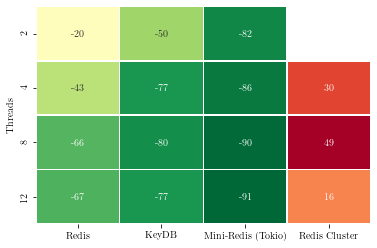

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -20\% &  -50\% &               -82\% &           N/A \\
       4 &  -43\% &  -77\% &               -86\% &           30\% \\
       8 &  -66\% &  -80\% &               -90\% &           49\% \\
      12 &  -67\% &  -77\% &               -91\% &           16\% \\
\bottomrule
\end{tabular}

Percentile: 0.999, Clients: 384


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-8%,-45%,-6%,N/A
1,4,-31%,-70%,-81%,29%
2,8,-48%,-79%,-88%,64%
3,12,-61%,-79%,-90%,51%


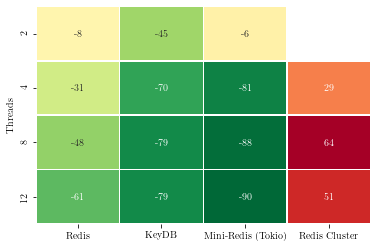

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &   -8\% &  -45\% &                -6\% &           N/A \\
       4 &  -31\% &  -70\% &               -81\% &           29\% \\
       8 &  -48\% &  -79\% &               -88\% &           64\% \\
      12 &  -61\% &  -79\% &               -90\% &           51\% \\
\bottomrule
\end{tabular}

Percentile: 0.999, Clients: 768


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-7%,-34%,15%,N/A
1,4,-34%,-68%,-60%,36%
2,8,-49%,-72%,-87%,80%
3,12,-59%,-75%,-87%,52%


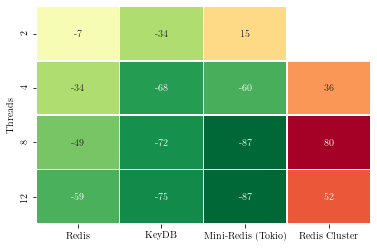

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &   -7\% &  -34\% &                15\% &           N/A \\
       4 &  -34\% &  -68\% &               -60\% &           36\% \\
       8 &  -49\% &  -72\% &               -87\% &           80\% \\
      12 &  -59\% &  -75\% &               -87\% &           52\% \\
\bottomrule
\end{tabular}

Percentile: 0.9999, Clients: 24


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,0%,-2%,-85%,N/A
1,4,0%,-3%,-86%,2%
2,8,0%,-3%,-86%,5%
3,12,0%,-3%,-86%,6%


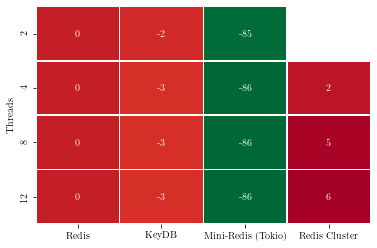

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &    0\% &   -2\% &               -85\% &           N/A \\
       4 &    0\% &   -3\% &               -86\% &            2\% \\
       8 &    0\% &   -3\% &               -86\% &            5\% \\
      12 &    0\% &   -3\% &               -86\% &            6\% \\
\bottomrule
\end{tabular}

Percentile: 0.9999, Clients: 96


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-38%,-48%,-80%,N/A
1,4,-45%,-50%,-87%,11%
2,8,-35%,-51%,-89%,21%
3,12,-19%,-51%,-88%,13%


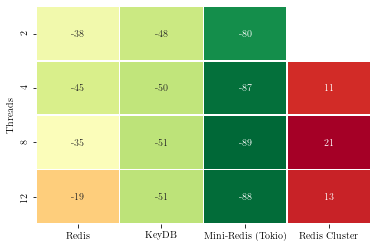

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -38\% &  -48\% &               -80\% &           N/A \\
       4 &  -45\% &  -50\% &               -87\% &           11\% \\
       8 &  -35\% &  -51\% &               -89\% &           21\% \\
      12 &  -19\% &  -51\% &               -88\% &           13\% \\
\bottomrule
\end{tabular}

Percentile: 0.9999, Clients: 192


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-29%,-57%,-78%,N/A
1,4,-51%,-76%,-86%,16%
2,8,-68%,-73%,-90%,28%
3,12,-64%,-70%,-91%,16%


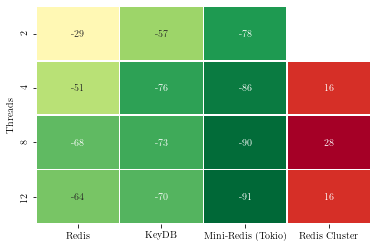

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -29\% &  -57\% &               -78\% &           N/A \\
       4 &  -51\% &  -76\% &               -86\% &           16\% \\
       8 &  -68\% &  -73\% &               -90\% &           28\% \\
      12 &  -64\% &  -70\% &               -91\% &           16\% \\
\bottomrule
\end{tabular}

Percentile: 0.9999, Clients: 384


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-18%,-53%,-8%,N/A
1,4,-42%,-74%,-78%,61%
2,8,-57%,-82%,-84%,178%
3,12,-67%,-77%,-87%,62%


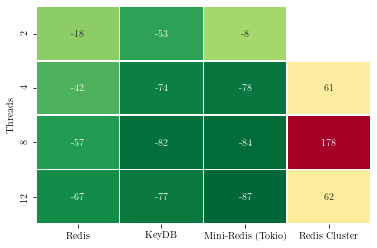

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -18\% &  -53\% &                -8\% &           N/A \\
       4 &  -42\% &  -74\% &               -78\% &           61\% \\
       8 &  -57\% &  -82\% &               -84\% &          178\% \\
      12 &  -67\% &  -77\% &               -87\% &           62\% \\
\bottomrule
\end{tabular}

Percentile: 0.9999, Clients: 768


,Threads,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,2,-33%,-43%,-17%,N/A
1,4,-53%,-73%,-71%,-10%
2,8,-67%,-81%,-83%,15%
3,12,-71%,-82%,-87%,42%


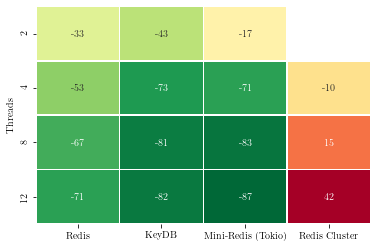

\begin{tabular}{rllll}
\toprule
 Threads & Redis & KeyDB & Mini-Redis (Tokio) & Redis Cluster \\
\midrule
       2 &  -33\% &  -43\% &               -17\% &           N/A \\
       4 &  -53\% &  -73\% &               -71\% &          -10\% \\
       8 &  -67\% &  -81\% &               -83\% &           15\% \\
      12 &  -71\% &  -82\% &               -87\% &           42\% \\
\bottomrule
\end{tabular}



In [33]:
dfs_latencies = {}
dfs_latencies2 = {}
for idx_p, percentile in enumerate(PERCENTILES):
    dfs_latencies[percentile] = {}
    dfs_latencies2[percentile] = {}
    for idx_c, clients in enumerate(CLIENTS_PER_MEMTIER_THREAD):
        dfs_latencies[percentile][clients] = pd.DataFrame(columns=['Threads'] + DB_NAMES)
        dfs_latencies2[percentile][clients] = new_threads_df()
        redis_baseline = None
        for thread in THREADS:
            row = {}
            row['Threads'] = thread
            row2 = {}
            row2['Threads'] = thread
            thresh = False
            for idx, db in enumerate(DATABASES):
                if db == 'redis-cluster' and thread < 4:
                    row[DB_NAME(db)] = f'N/A'
                    row2[DB_NAME(db)] = float('NaN')
                    continue
                tail = results[db][thread][clients]['tail'][idx_p]
                if thread == 1 and db == 'redis':
                    # redis_baseline.append(tail)
                    redis_baseline = tail
                elif thread >= 2:
                    base = redis_baseline
                    #print(f'Redis base: {base}')
                    #print(f'{DB_NAME(db)} tail: {tail}')
                    row[DB_NAME(db)] = f'{imp_baseline(base, tail)}%'
                    row2[DB_NAME(db)] = imp_baseline(base, tail)
                    thresh = True
            if thresh:
                dfs_latencies[percentile][clients] =  dfs_latencies[percentile][clients].append(row, ignore_index=True)
                dfs_latencies2[percentile][clients] =  dfs_latencies2[percentile][clients].append(row2, ignore_index=True)
        dfs_latencies[percentile][clients]['Threads'] = dfs_latencies[percentile][clients]['Threads'].astype(int)
        #dfs_latencies[percentile][clients].set_index('Threads', inplace=True)
        print(f'Percentile: {percentile}, Clients: {clients * vCPUs}')
        display(HTML(dfs_latencies[percentile][clients].to_html()))
        #dfs_latencies2[percentile][clients].style.background_gradient(cmap='Blues')
        # display(HTML(dfs_latencies2[percentile][clients].to_html()))
        #sns.heatmap(dfs_latencies2[percentile][clients], annot=True)
        plt_heatmap(dfs_latencies2[percentile][clients], f'./latencies_heatmap/latencies_percentile_{percentile}_clients_{clients}.pgf')
        print(dfs_latencies[percentile][clients].to_latex(index=False))

In [34]:
dfs_latencies2[0.95][4]['Redis'].mean()

-39.75

In [35]:
df_latency_res = pd.DataFrame(columns=['Percentile'] + DB_NAMES)
for idx_p, percentile in enumerate(PERCENTILES):
    row = {}
    row['Percentile'] = percentile
    for idx_d, db in enumerate(DATABASES):
        means = []
        for idx_c, clients in enumerate(CLIENTS_PER_MEMTIER_THREAD):
            means.append(dfs_latencies2[percentile][clients][DB_NAME(db)].mean())
        row[DB_NAME(db)] = int(round(np.mean(means), 0))
    df_latency_res =  df_latency_res.append(row, ignore_index=True)

In [36]:
def plt_heatmap_perc(df, save = None, title = None, suptitle = None):
    df = df.set_index('Percentile')
    fig, ax = plt.subplots()
    #display(HTML(df.to_html()))
    sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt='g', cbar=False)
    ax.set_yticklabels(['P95', 'P99', 'P99.9', 'P99.99'])
    if save:
        plt.savefig(save)
    if title:
        plt.title(title)
    if suptitle:
        plt.suptitle(suptitle)
    #plt.savefig(f'./latencies/latencies_threads_{thread}_clients_{clients}.pgf')
    plt.show()

,Percentile,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,0.9500,-37.0,-58.0,-29.0,58.0
1,0.9900,-39.0,-60.0,-33.0,52.0
2,0.9990,-36.0,-65.0,-70.0,40.0
3,0.9999,-38.0,-53.0,-77.0,31.0


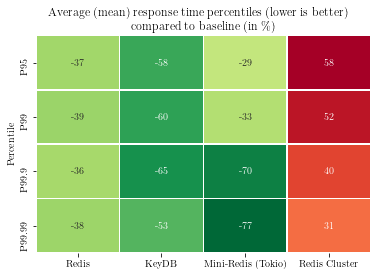

\begin{tabular}{lrrrrr}
\toprule
{} &  Percentile &  Redis &  KeyDB &  Mini-Redis (Tokio) &  Redis Cluster \\
\midrule
0 &      0.9500 &  -37.0 &  -58.0 &               -29.0 &           58.0 \\
1 &      0.9900 &  -39.0 &  -60.0 &               -33.0 &           52.0 \\
2 &      0.9990 &  -36.0 &  -65.0 &               -70.0 &           40.0 \\
3 &      0.9999 &  -38.0 &  -53.0 &               -77.0 &           31.0 \\
\bottomrule
\end{tabular}



In [37]:
display(HTML(df_latency_res.to_html()))
plt_heatmap_perc(df_latency_res, f'./average_latencies/latencies_percentile_avg.pgf', 'compared to baseline (in \%)', 'Average (mean) response time percentiles (lower is better)')
print(df_latency_res.to_latex())

In [38]:
dfs_latencies_without_tokio_outliers = {}
for idx_p, percentile in enumerate(PERCENTILES):
    dfs_latencies_without_tokio_outliers[percentile] = {}
    for idx_c, clients in enumerate(CLIENTS_PER_MEMTIER_THREAD):
        dfs_latencies_without_tokio_outliers[percentile][clients] = pd.DataFrame(columns=['Threads'] + DB_NAMES)
        redis_baseline = None
        for thread in THREADS:
            if thread > 1 and (clients * vCPUs) / thread >= 192:
                    continue
            row = {}
            row['Threads'] = thread
            thresh = False
            for idx, db in enumerate(DATABASES):
                if db == 'redis-cluster' and thread < 4:
                    row[DB_NAME(db)] = float('NaN')
                    continue
                tail = results[db][thread][clients]['tail'][idx_p]
                if thread == 1 and db == 'redis':
                    # redis_baseline.append(tail)
                    redis_baseline = tail
                elif thread >= 2:
                    base = redis_baseline
                    row[DB_NAME(db)] = imp_baseline(base, tail)
                    thresh = True
            if thresh:
                dfs_latencies_without_tokio_outliers[percentile][clients] =  dfs_latencies_without_tokio_outliers[percentile][clients].append(row, ignore_index=True)
        dfs_latencies_without_tokio_outliers[percentile][clients].reset_index(drop=True, inplace=True)
        # print(f'Percentile: {percentile}, Clients: {clients * vCPUs}')
        # display(HTML(dfs_latencies_without_tokio_outliers[percentile][clients].to_html()))

In [39]:
df_latency_without_tokio_outliers_res = pd.DataFrame(columns=['Percentile'] + DB_NAMES)
for idx_p, percentile in enumerate(PERCENTILES):
    row = {}
    row['Percentile'] = percentile
    for idx_d, db in enumerate(DATABASES):
        sums = 0
        lens = 0
        for idx_c, clients in enumerate(CLIENTS_PER_MEMTIER_THREAD):
            df_row = dfs_latencies_without_tokio_outliers[percentile][clients][DB_NAME(db)]
            sums += df_row.sum()
            lens += len(df_row)
        row[DB_NAME(db)] = int(round(sums / lens, 0))
    df_latency_without_tokio_outliers_res =  df_latency_without_tokio_outliers_res.append(row, ignore_index=True)

In [40]:
display(HTML(df_latency_without_tokio_outliers_res.to_html()))
print(df_latency_without_tokio_outliers_res.to_latex(index=False))

,Percentile,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,0.9500,-37.0,-60.0,-54.0,49.0
1,0.9900,-37.0,-61.0,-58.0,44.0
2,0.9990,-40.0,-67.0,-79.0,33.0
3,0.9999,-38.0,-52.0,-85.0,28.0


\begin{tabular}{rrrrr}
\toprule
 Percentile &  Redis &  KeyDB &  Mini-Redis (Tokio) &  Redis Cluster \\
\midrule
     0.9500 &  -37.0 &  -60.0 &               -54.0 &           49.0 \\
     0.9900 &  -37.0 &  -61.0 &               -58.0 &           44.0 \\
     0.9990 &  -40.0 &  -67.0 &               -79.0 &           33.0 \\
     0.9999 &  -38.0 &  -52.0 &               -85.0 &           28.0 \\
\bottomrule
\end{tabular}



,Percentile,Redis,KeyDB,Mini-Redis (Tokio),Redis Cluster
0,0.9500,-37.0,-60.0,-54.0,49.0
1,0.9900,-37.0,-61.0,-58.0,44.0
2,0.9990,-40.0,-67.0,-79.0,33.0
3,0.9999,-38.0,-52.0,-85.0,28.0


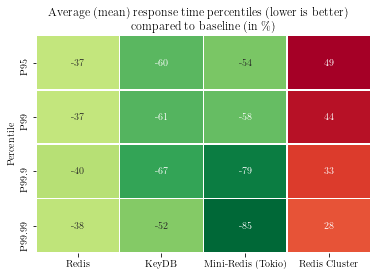

\begin{tabular}{lrrrrr}
\toprule
{} &  Percentile &  Redis &  KeyDB &  Mini-Redis (Tokio) &  Redis Cluster \\
\midrule
0 &      0.9500 &  -37.0 &  -60.0 &               -54.0 &           49.0 \\
1 &      0.9900 &  -37.0 &  -61.0 &               -58.0 &           44.0 \\
2 &      0.9990 &  -40.0 &  -67.0 &               -79.0 &           33.0 \\
3 &      0.9999 &  -38.0 &  -52.0 &               -85.0 &           28.0 \\
\bottomrule
\end{tabular}



In [43]:
display(HTML(df_latency_without_tokio_outliers_res.to_html()))
plt_heatmap_perc(df_latency_without_tokio_outliers_res, f'./average_latencies/latencies_percentile_avg_woutliers.pgf', 'compared to baseline (in \%)', 'Average (mean) response time percentiles (lower is better)')
print(df_latency_without_tokio_outliers_res.to_latex())